In [79]:
pip install shapely

In [80]:
import pandas as pd
import matplotlib
import json
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
from scipy.interpolate import CubicSpline, interp1d
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [81]:
def load_labelme_annotations(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    road_polygons = []
    for shape in data['shapes']:
        if shape['shape_type'] == 'polygon':
            polygon_coords = shape['points']
            road_polygons.append(Polygon(polygon_coords))

    return road_polygons

def classify_road(x, y, road_polygons):
    point = Point(x, y)
    for road_idx, road in enumerate(road_polygons):
        if road.contains(point):
            return road_idx
    return None

df = pd.read_csv('/content/drive/MyDrive/Data_set/Frames.csv')

json_file = '/content/drive/MyDrive/Data_set/00001-mark2.json'
road_polygons = load_labelme_annotations(json_file)

df['road'] = df.apply(lambda row: classify_road(row['x_img [px]'], row['y_img [px]'], road_polygons), axis=1)
print(df.head())

   Time [s]  ID            Type  x_img [px]  y_img [px]  Angle_img [rad]  \
0      80.0   3      Motorcycle        3130         902         5.118048   
1      80.0   4      Motorcycle        3119         900         4.937148   
2      80.0   6             Bus        1800         752         3.133348   
3      80.0   7             Car         955        1563         0.556948   
4      80.0   9  Medium Vehicle         536         739         2.497348   

   timestamp  road  
0        1.0   NaN  
1        1.0  14.0  
2        1.0   0.0  
3        1.0   NaN  
4        1.0   0.0  


In [82]:
df.isnull().sum()

Time [s]               0
ID                     0
Type                   0
x_img [px]             0
y_img [px]             0
Angle_img [rad]        0
timestamp              0
road               11912
dtype: int64

In [83]:
df = df.dropna()

In [84]:
df['road'].unique()

array([14.,  0., 10.,  9.,  7., 15.,  6., 13.,  1.,  2.,  3.,  8.,  4.,
       12.,  5., 11.])

In [85]:
df.rename(columns={'Time [s]': 'time', 'ID': 'id', 'Type' : 'type', 'x_img [px]': 'x', 'y_img [px]': 'y', 'Angle_img [rad]': 'angle', 'timestamp': 'timestamp'}, inplace=True)


<ipython-input-85-8df9b41aed89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Time [s]': 'time', 'ID': 'id', 'Type' : 'type', 'x_img [px]': 'x', 'y_img [px]': 'y', 'Angle_img [rad]': 'angle', 'timestamp': 'timestamp'}, inplace=True)


In [86]:
df.columns

Index(['time', 'id', 'type', 'x', 'y', 'angle', 'timestamp', 'road'], dtype='object')

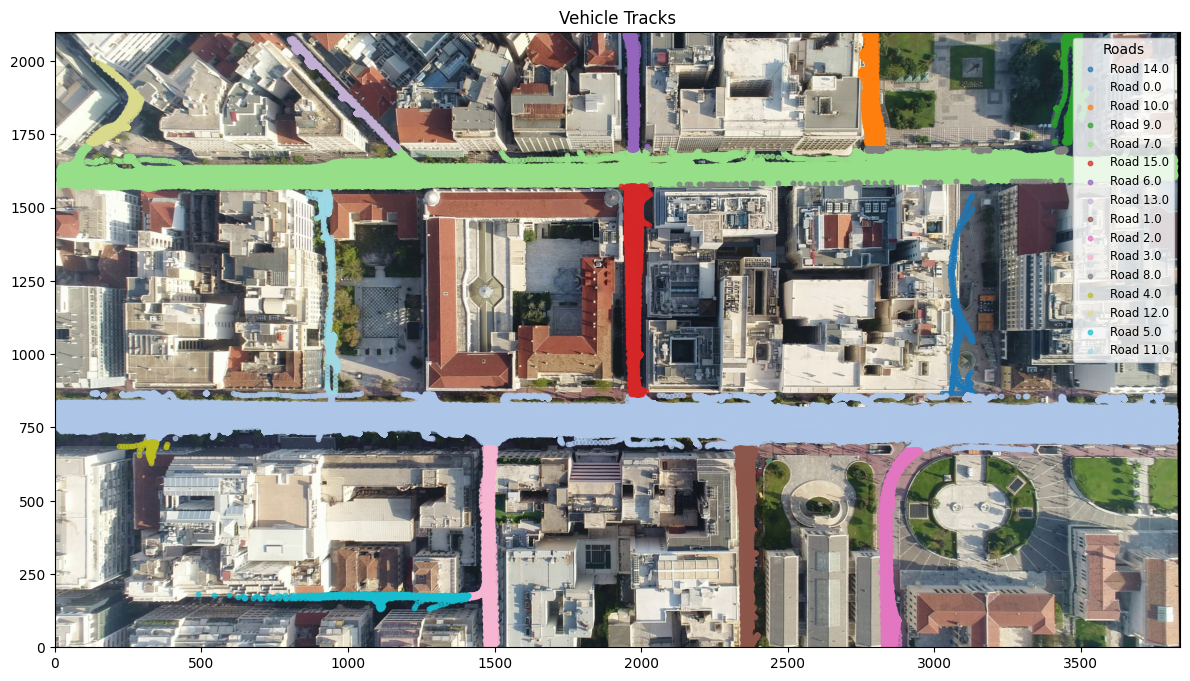

In [87]:
background = mpimg.imread('/content/drive/MyDrive/Data_set/00001.jpg')

unique_roads = df['road'].unique()
colors = plt.get_cmap('tab20', len(unique_roads))
road_to_color = {road: colors(i) for i, road in enumerate(unique_roads)}

fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(background)

for road in unique_roads:
    sub_df = df[df['road'] == road]
    ax.scatter(sub_df['x'], sub_df['y'],
               color=road_to_color[road], label=f'Road {road}',
               s=10, alpha=0.7)

ax.invert_yaxis()

plt.title('Vehicle Tracks')
plt.legend(fontsize='small', loc='upper right', title='Roads')
plt.tight_layout()

plt.show()

In [88]:
df = df[df['type'].str.lower() != 'motorcycle']

In [89]:
def smooth_trajectory(x, y, num_points=100, smoothing='spline'):
    if len(x) < 2:
        return x, y

    t = np.arange(len(x))

    if smoothing == 'savgol' and len(x) >= 5:
        # Savitzky-Golay filter for noise reduction
        window_length = min(len(x) // 2 * 2 - 1, 15)  # Must be odd and <= length
        if window_length >= 3:
            x_smooth = savgol_filter(x, window_length, 2)
            y_smooth = savgol_filter(y, window_length, 2)
            return x_smooth, y_smooth

    if len(x) >= 4 and smoothing == 'spline':
        # cubic spline for 4+ points
        cs_x = CubicSpline(t, x)
        cs_y = CubicSpline(t, y)
        t_new = np.linspace(t[0], t[-1], num_points)
        return cs_x(t_new), cs_y(t_new)
    else:
        # linear interpolation for shorter trajectories
        cs_x = interp1d(t, x, kind='linear', fill_value="extrapolate")
        cs_y = interp1d(t, y, kind='linear', fill_value="extrapolate")
        t_new = np.linspace(t[0], t[-1], num_points)
        return cs_x(t_new), cs_y(t_new)


def extract_trajectory_points(df_road, min_points=3):
    points = []
    traj_info = []

    # consider vehicles with enough data points
    for vehicle_id, group in df_road.groupby('id'):
        group = group.sort_values('timestamp')
        if len(group) < min_points:
            continue

        x, y = group['x'].values, group['y'].values
        vehicle_type = group['type'].iloc[0]

        try:
            x_smooth, y_smooth = smooth_trajectory(x, y)

            percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
            for p in percentiles:
                idx = int(len(x_smooth) * p)
                if 0 <= idx < len(x_smooth):
                    points.append((x_smooth[idx], y_smooth[idx]))
                    traj_info.append({
                        'id': vehicle_id,
                        'type': vehicle_type,
                        'percentile': p
                    })
        except Exception as e:
            print(f"Error processing vehicle {vehicle_id}: {e}")

    return np.array(points) if points else np.empty((0, 2)), traj_info


In [90]:
def segment_road_by_curvature(points, traj_info, max_angle=30, min_segment_points=10):
    """Segment a road based on curvature changes."""
    if len(points) < 3:
        return [points] if len(points) > 0 else []

    # Group points by trajectory ID to maintain continuity
    traj_groups = {}
    for idx, info in enumerate(traj_info):
        traj_id = info['id']
        if traj_id not in traj_groups:
            traj_groups[traj_id] = []
        traj_groups[traj_id].append(idx)

    # Fit PCA to get the general road direction
    pca = PCA(n_components=2)
    pca.fit(points)
    main_direction = pca.components_[0]

    # Calculate angles relative to main direction
    segments = []
    current_segment_indices = []
    prev_angle = None

    # Process each trajectory
    for traj_id, indices in traj_groups.items():
        if len(indices) < 2:
            continue

        traj_points = points[indices]

        # Calculate direction vectors between consecutive points
        directions = np.diff(traj_points, axis=0)

        # Normalize directions
        norms = np.linalg.norm(directions, axis=1)
        valid_dirs = norms > 0
        normalized_dirs = np.zeros_like(directions)
        normalized_dirs[valid_dirs] = directions[valid_dirs] / norms[valid_dirs, np.newaxis]

        # Calculate angles relative to main direction
        dot_products = np.sum(normalized_dirs * main_direction, axis=1)
        angles = np.arccos(np.clip(dot_products, -1.0, 1.0)) * 180 / np.pi

        # Detect significant angle changes
        angle_changes = np.diff(angles)
        change_points = np.where(np.abs(angle_changes) > max_angle)[0]

        # segments based on angle changes
        if len(change_points) == 0:
            segments.append(traj_points)
        else:
            start_idx = 0
            for end_idx in change_points:
                segment = traj_points[start_idx:end_idx+1]
                if len(segment) >= min_segment_points:
                    segments.append(segment)
                start_idx = end_idx + 1

            if start_idx < len(traj_points) and len(traj_points[start_idx:]) >= min_segment_points:
                segments.append(traj_points[start_idx:])

    return segments if segments else [points]


In [91]:
def project_points_to_lateral(points, segment):
    """Project points onto road segment"""
    if len(segment) < 2:
        return np.zeros(len(points))

    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)

        if len(segment) >= 3:
            diffs = np.diff(segment, axis=0)
            dot_products = np.sum(diffs[:-1] * diffs[1:], axis=1)
            norms = np.linalg.norm(diffs[:-1], axis=1) * np.linalg.norm(diffs[1:], axis=1)
            normalized_dots = dot_products / (norms + 1e-10)  # division by zero

            is_collinear = np.all(normalized_dots > 0.99)

            if is_collinear:
                direction = segment[-1] - segment[0]
                direction = direction / np.linalg.norm(direction)
                ortho_direction = np.array([-direction[1], direction[0]])

                centered_points = points - segment[0]
                lateral_positions = np.dot(centered_points, ortho_direction)
                return lateral_positions

        try:
            pca = PCA(n_components=2)
            pca.fit(segment)

            transformed = pca.transform(points)
            lateral_positions = transformed[:, 1]

            return lateral_positions
        except Exception as e:
            print(f"PCA error: {e}")
            # Fallback method
            if len(segment) >= 2:
                direction = segment[-1] - segment[0]
                direction = direction / (np.linalg.norm(direction) + 1e-10)
                ortho_direction = np.array([-direction[1], direction[0]])

                centered_points = points - segment[0]
                lateral_positions = np.dot(centered_points, ortho_direction)
                return lateral_positions
            else:
                return np.zeros(len(points))


In [92]:
def remove_outliers(data, factor=1.5):
    """Remove outliers using IQR method"""
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]


In [93]:
def estimate_lanes(lateral_data, max_lanes=6, min_lanes=1):
    """Estimate number of lanes using multiple methods and validation."""
    if len(lateral_data) < 10:
        return [], 0, None

    cleaned_data = remove_outliers(lateral_data)
    if len(cleaned_data) < 5:
        return [], 0, None

    # Reshape for sklearn
    X = cleaned_data.reshape(-1, 1)

    methods = []

    # 1. GMM with BIC
    best_gmm = None
    best_bic = np.inf
    best_n_gmm = 0

    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)

        for n in range(min_lanes, max_lanes + 1):
            try:
                gmm = GaussianMixture(
                    n_components=n,
                    random_state=42,
                    covariance_type='full',
                    reg_covar=1e-3,
                    max_iter=100
                )
                gmm.fit(X)
                bic = gmm.bic(X)

                if bic < best_bic:
                    best_bic = bic
                    best_gmm = gmm
                    best_n_gmm = n
            except Exception as e:
                print(f"GMM error with {n} components: {e}")
                continue

    if best_gmm is not None:
        gmm_centers = np.sort(best_gmm.means_.flatten())
        gmm_labels = best_gmm.predict(X)
        methods.append({
            'method': 'GMM',
            'centers': gmm_centers,
            'n_lanes': best_n_gmm,
            'labels': gmm_labels,
            'score': -best_bic
        })

    # 2. KMeans with silhouette score
    best_kmeans = None
    best_n_kmeans = 0
    best_inertia = np.inf

    for n in range(min_lanes, max_lanes + 1):
        try:
            kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
            kmeans.fit(X)
            inertia = kmeans.inertia_

            if inertia < best_inertia:
                best_inertia = inertia
                best_kmeans = kmeans
                best_n_kmeans = n
        except:
            continue

    if best_kmeans is not None:
        kmeans_centers = np.sort(best_kmeans.cluster_centers_.flatten())
        kmeans_labels = best_kmeans.labels_
        methods.append({
            'method': 'KMeans',
            'centers': kmeans_centers,
            'n_lanes': best_n_kmeans,
            'labels': kmeans_labels,
            'score': -best_inertia
        })

    # 3. Density-based approach - kernel density estimation
    if len(cleaned_data) >= 20:
        try:
            from scipy.signal import find_peaks
            from scipy.stats import gaussian_kde

            kde = gaussian_kde(cleaned_data)
            x_eval = np.linspace(np.min(cleaned_data), np.max(cleaned_data), 1000)
            density = kde(x_eval)

            # Find peaks in density
            peaks, _ = find_peaks(density, height=0.1*np.max(density), distance=20)
            peak_positions = x_eval[peaks]

            if min_lanes <= len(peak_positions) <= max_lanes:
                kde_labels = np.zeros(len(X))
                for i, val in enumerate(cleaned_data):
                    kde_labels[i] = np.argmin(np.abs(val - peak_positions))

                methods.append({
                    'method': 'KDE',
                    'centers': np.sort(peak_positions),
                    'n_lanes': len(peak_positions),
                    'labels': kde_labels,
                    'score': len(peak_positions)
                })
        except:
            pass

    if not methods:
        return [], 0, None

    methods.sort(key=lambda x: x['score'], reverse=True)
    best_method = methods[0]

    return best_method['centers'], best_method['n_lanes'], best_method['labels']

In [94]:
def visualize_lane_detection(df, json_file, image_data):
    road_polygons = load_labelme_annotations(json_file)
    if 'road' not in df.columns:
        df['road'] = df.apply(lambda row: classify_road(row['x'], row['y'], road_polygons), axis=1)

    background = image_data

    # Dictionary to store lane counts
    lane_info = {}

    for road in df['road'].unique():
        if pd.isna(road):
            continue

        df_road = df[df['road'] == road]
        points, traj_info = extract_trajectory_points(df_road, min_points=3)
        if len(points) == 0:
            print(f"Road {road}: Not enough points to process.")
            lane_info[road] = 0
            continue

        segments = segment_road_by_curvature(points, traj_info)
        if not segments:
            print(f"Road {road}: Could not segment road properly.")
            lane_info[road] = 0
            continue

        all_lateral = []

        for i, segment in enumerate(segments):
            if len(segment) < 3:
                continue

            lateral = project_points_to_lateral(points, segment)
            all_lateral.extend(lateral)

        all_lateral = np.array(all_lateral)
        if len(all_lateral) < 10:
            print(f"Road {road}: Not enough lateral data.")
            lane_info[road] = 0
            continue

        # Estimate lanes
        centers, lane_count, labels = estimate_lanes(all_lateral, min_lanes=1, max_lanes=6)

        if lane_count == 0:
            print(f"Road {road}: Could not detect lanes.")
            lane_info[road] = 0
            continue

        print(f"Road {road}: Detected {lane_count} lanes.")
        lane_info[road] = lane_count

        # Visualize lane detection
        plt.figure(figsize=(10, 6))
        plt.hist(all_lateral, bins=30, alpha=0.7, density=True, color='skyblue', label='Lateral Positions')

        if lane_count > 0:
            x = np.linspace(min(all_lateral), max(all_lateral), 1000)

            if labels is not None:
                unique_labels = np.unique(labels)
                cmap = plt.get_cmap('tab10', len(unique_labels))

                for i, center in enumerate(centers):
                    plt.axvline(center, color=cmap(i), linestyle='--', lw=2, label=f'Lane {i+1} center')
                    dist_to_center = np.abs(all_lateral - center)
                    threshold = np.percentile(dist_to_center, 20)
                    lane_points = all_lateral[dist_to_center <= threshold]

                    if len(lane_points) > 1:
                        std = np.std(lane_points)
                        plt.plot(x, norm.pdf(x, center, std) * 0.5,
                                 color=cmap(i), alpha=0.5)

        plt.title(f"Road {road}: Lane Detection - {lane_count} lanes")
        plt.xlabel("Lateral Position")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(background)

    unique_roads = df['road'].dropna().unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_roads)))
    road_to_color = {road: colors[i] for i, road in enumerate(unique_roads)}
    road_centers = {}

    for road in unique_roads:
        sub_df = df[df['road'] == road]
        label = f'Road {road}'
        if road in lane_info and lane_info[road] > 0:
            label += f' ({lane_info[road]} lanes)'

        ax.scatter(sub_df['x'], sub_df['y'],
                  color=road_to_color[road], label=label,
                  s=10, alpha=0.7)

        x_center = sub_df['x'].mean()
        y_center = sub_df['y'].mean()

        road_centers[road] = (x_center, y_center)
        ax.text(x_center, y_center, f"Road {road}\n{lane_info.get(road, 0)} lanes",
                color='white', fontweight='bold', ha='center', va='center',
                bbox=dict(facecolor=road_to_color[road], alpha=0.7, boxstyle='round,pad=0.5'))

    ax.set_title('Vehicle Tracks with Detected Lane Counts')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


    return lane_info


Road 0.0: Detected 6 lanes.


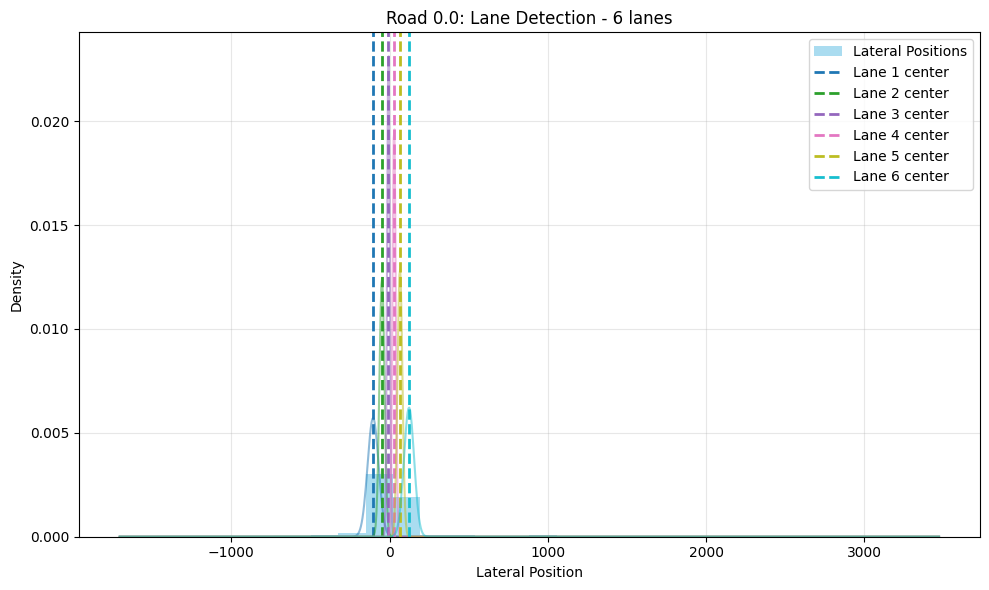

Road 9.0: Detected 1 lanes.


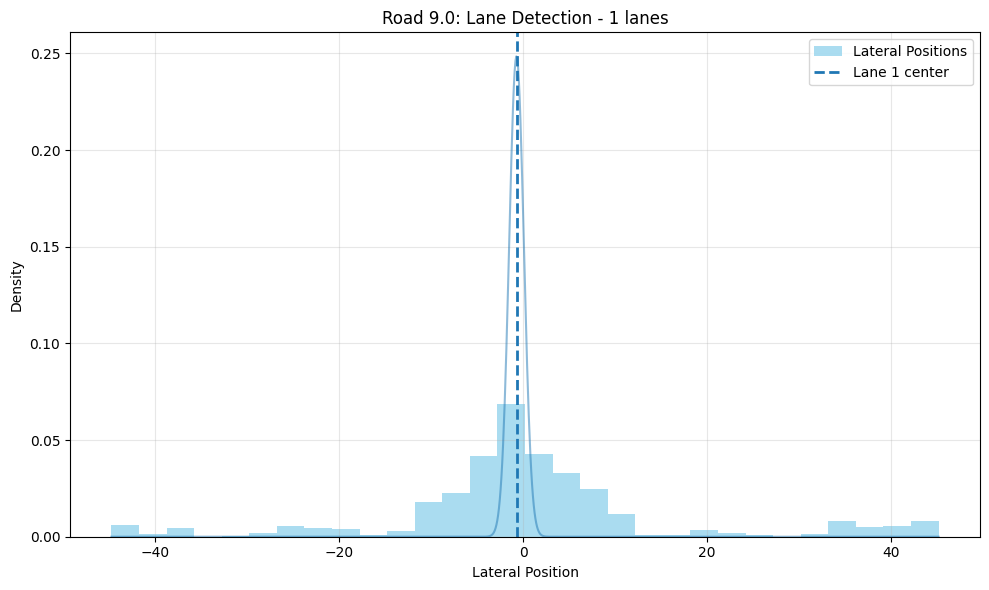

Road 15.0: Detected 2 lanes.


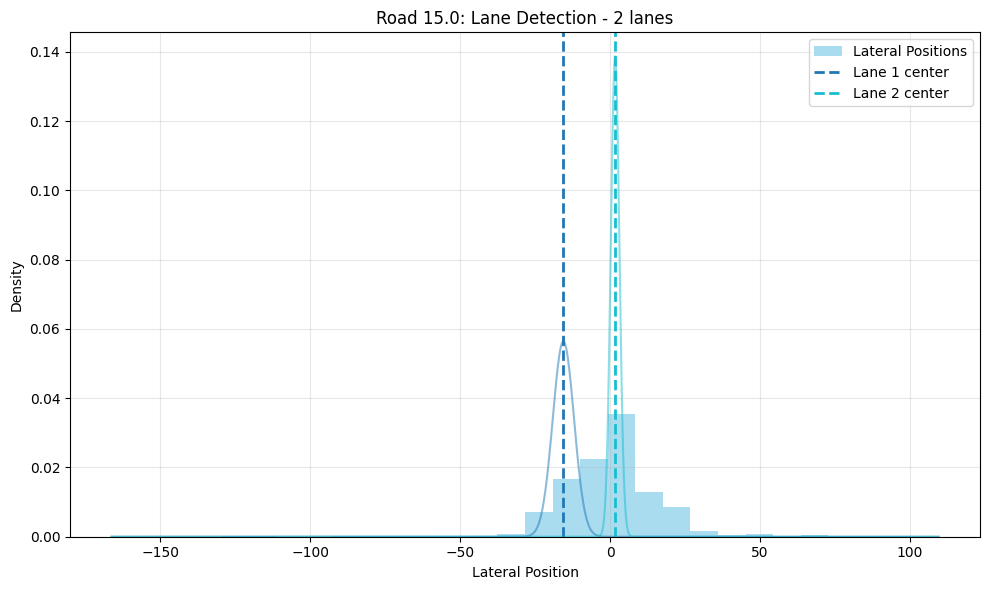

Road 7.0: Detected 3 lanes.


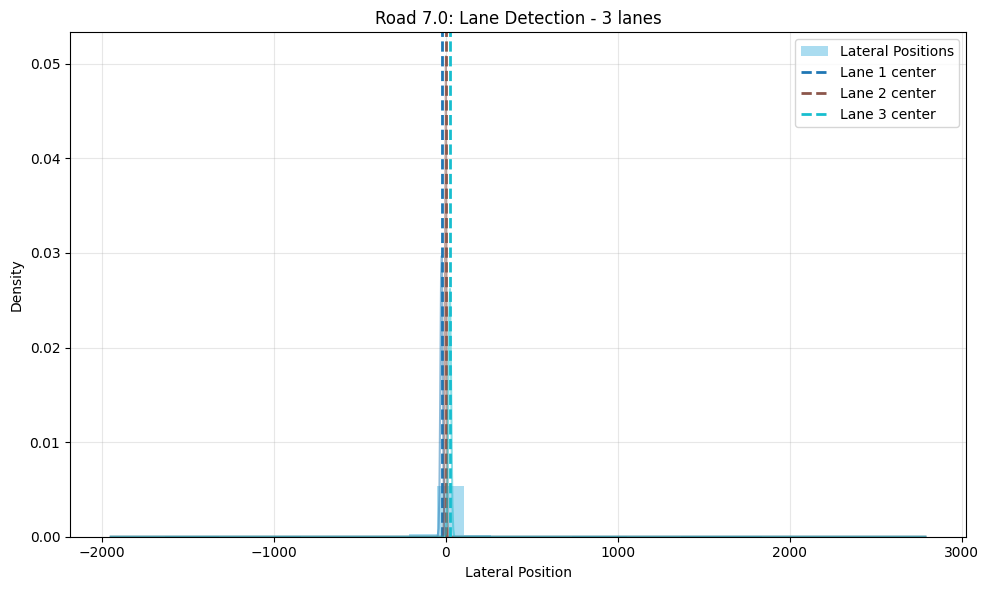

Road 6.0: Detected 2 lanes.


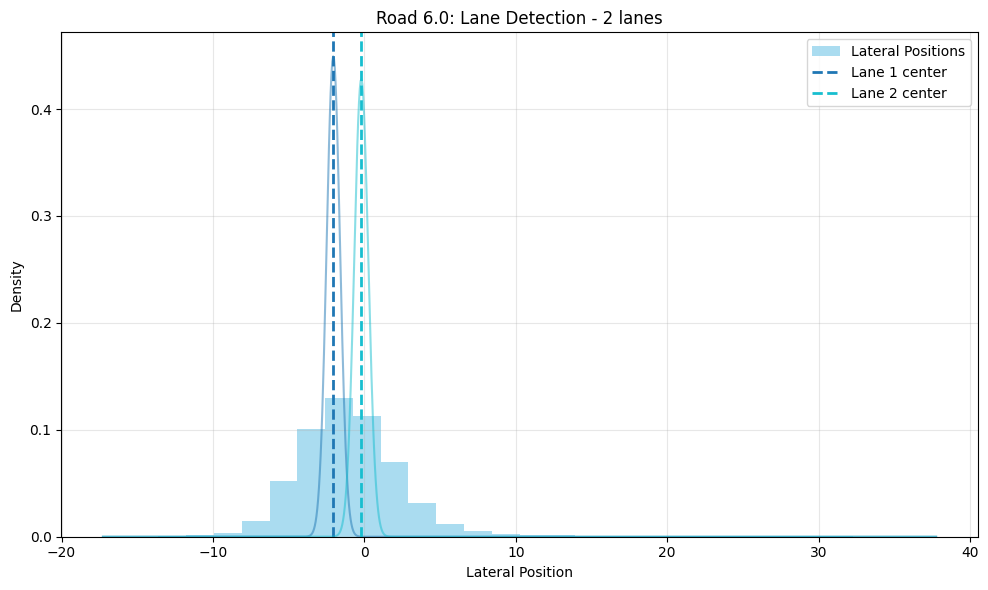

Road 13.0: Detected 2 lanes.


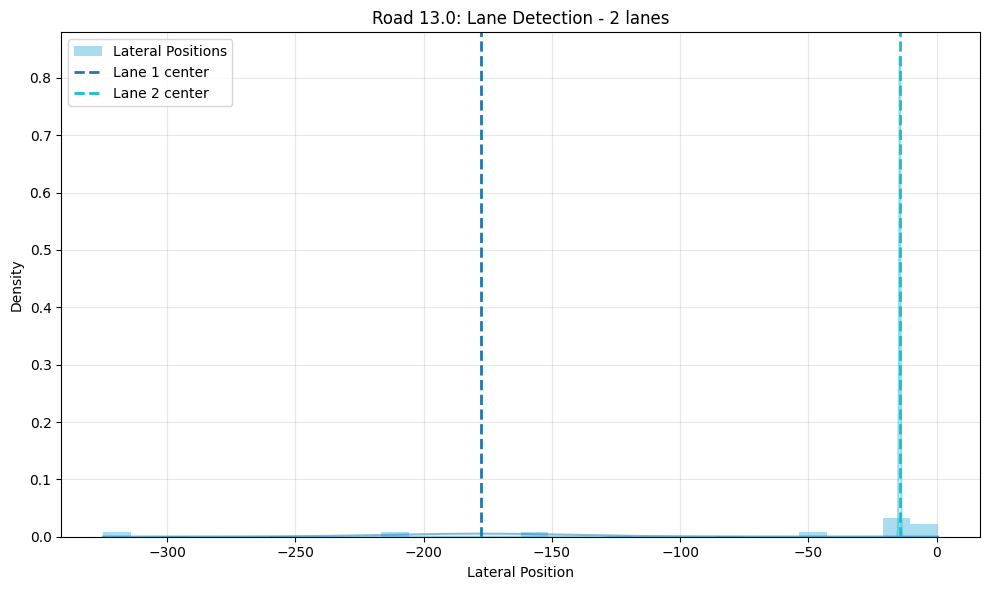

Road 1.0: Detected 3 lanes.


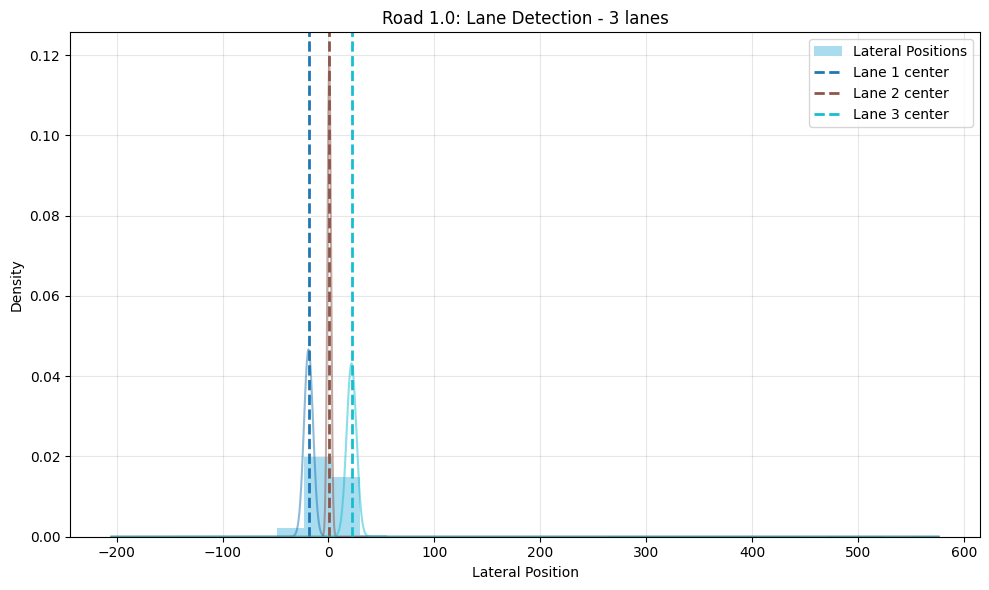

Road 2.0: Detected 1 lanes.


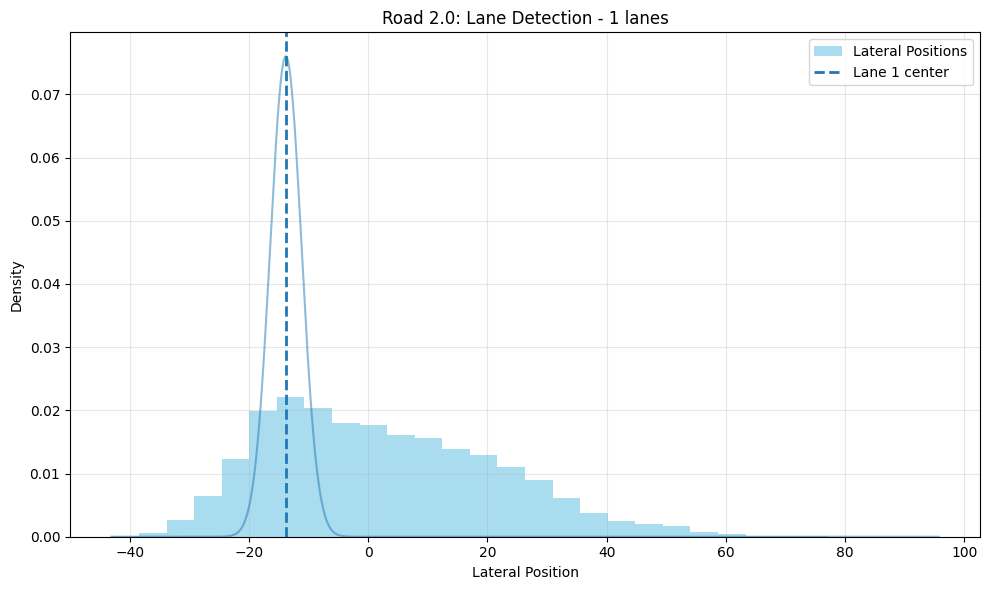

Road 3.0: Detected 1 lanes.


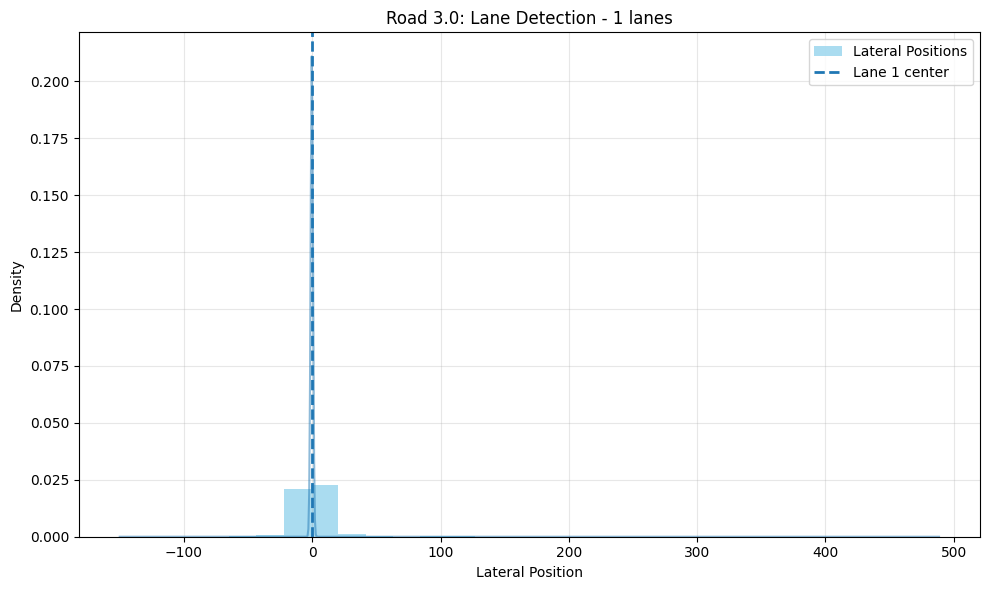

Road 4.0: Detected 1 lanes.


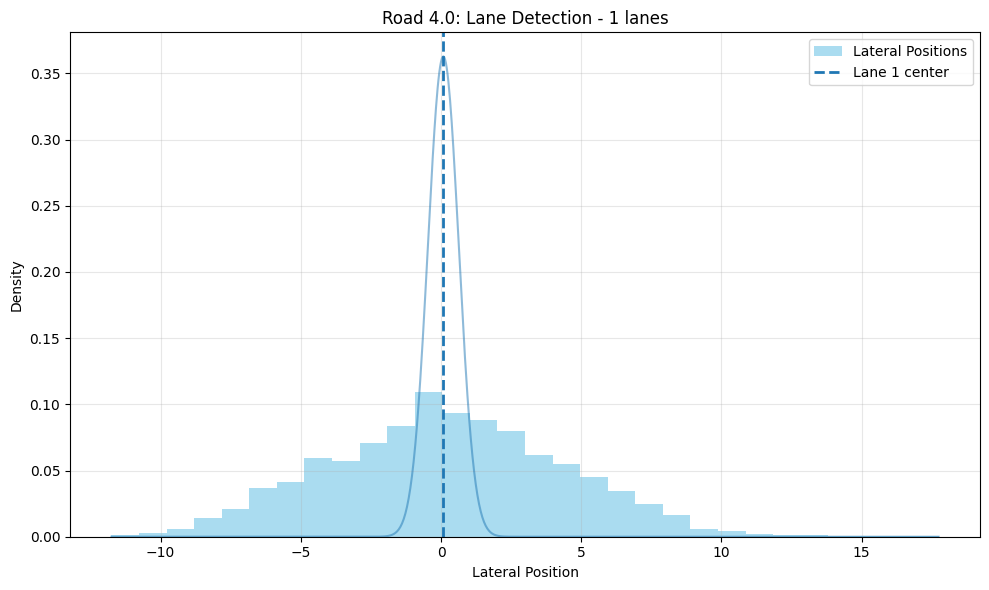

Road 8.0: Detected 5 lanes.


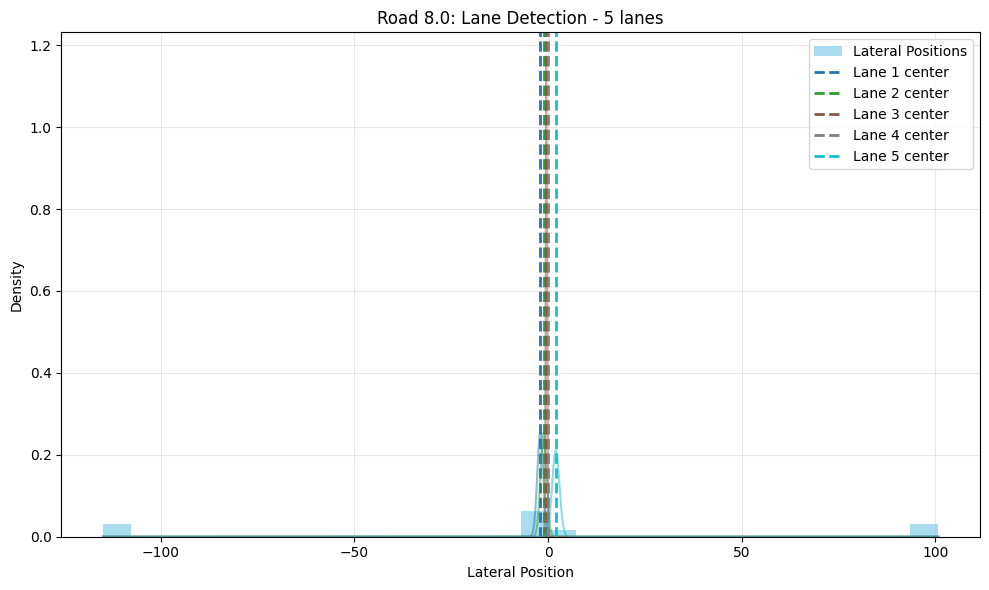

Road 5.0: Detected 2 lanes.


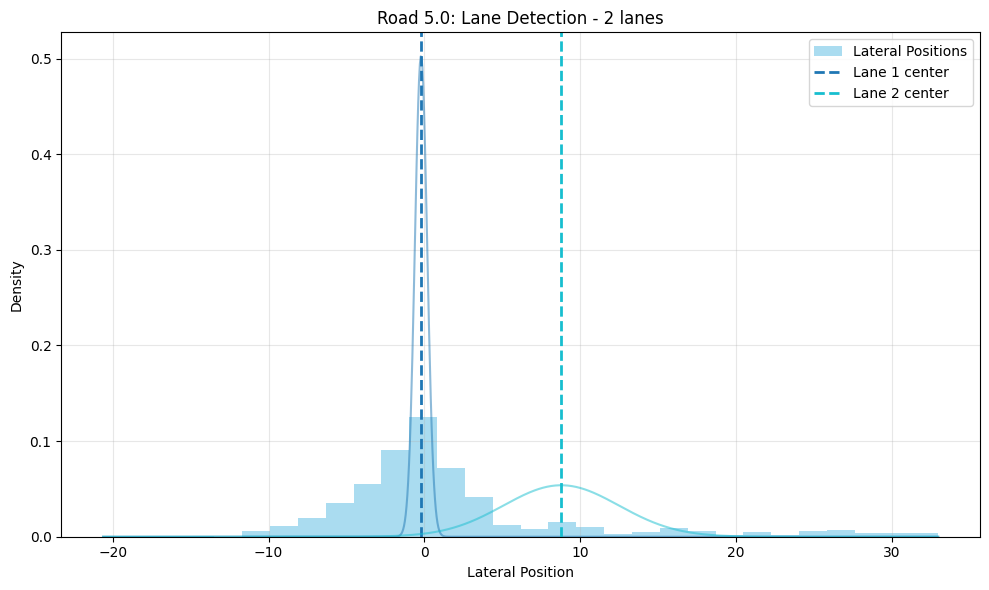

Road 10.0: Detected 2 lanes.


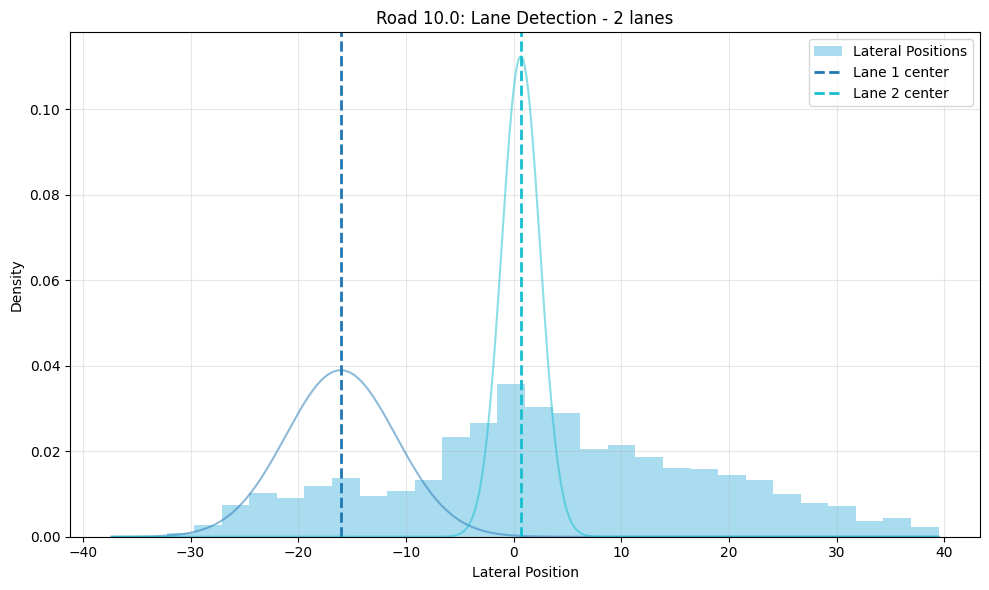

Road 14.0: Not enough lateral data.
Road 12.0: Detected 6 lanes.


/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


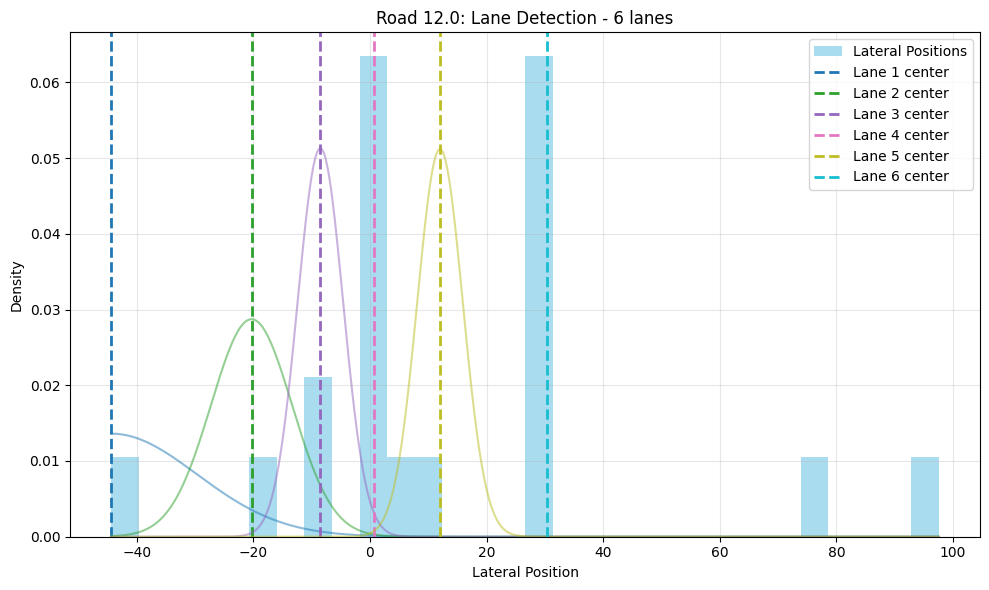

Road 11.0: Not enough lateral data.


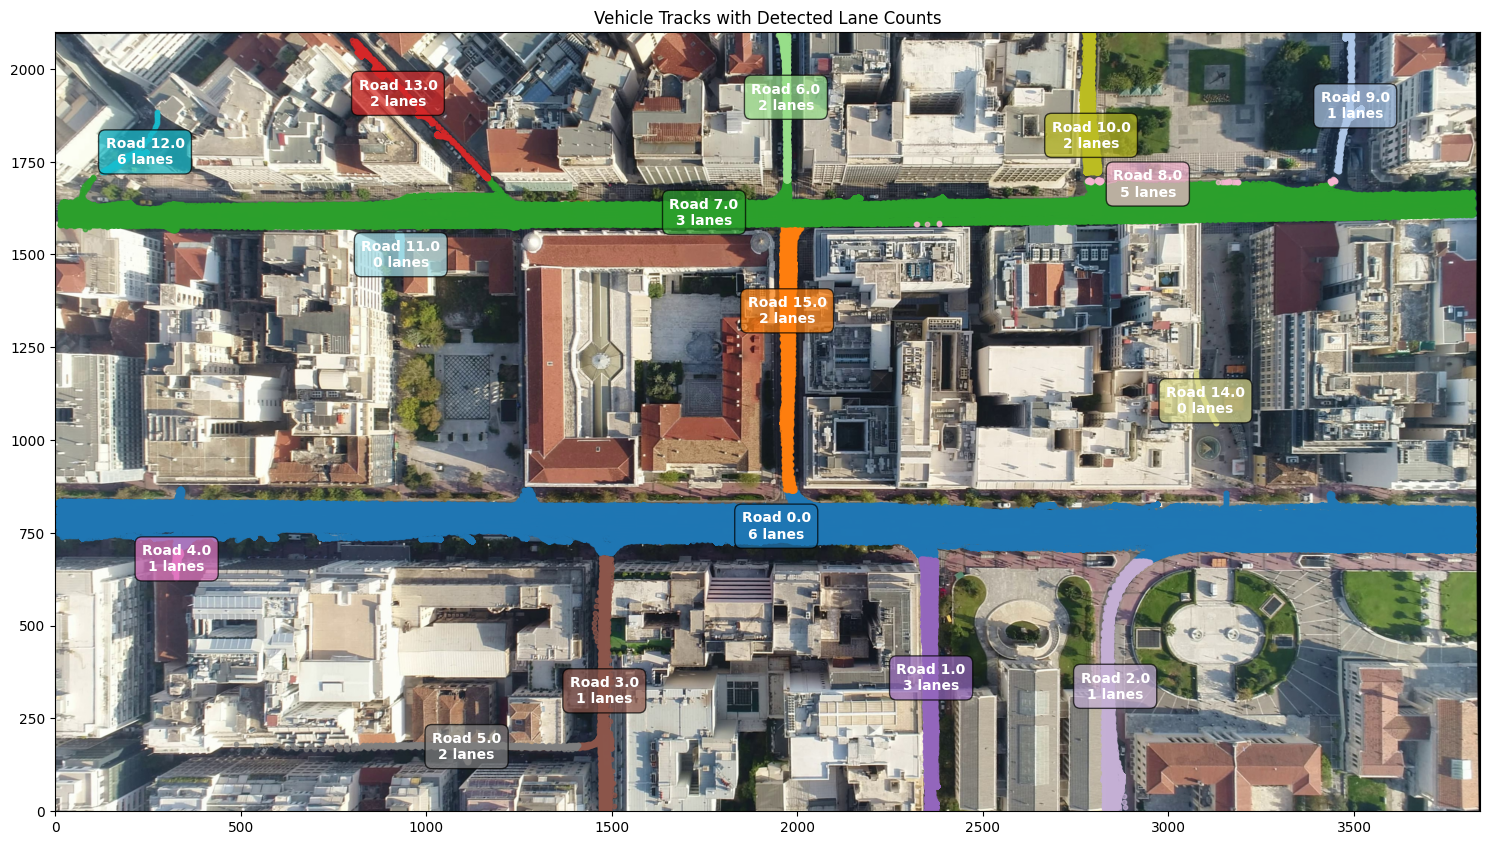

In [95]:
lane_info = visualize_lane_detection(df, json_file, background)

In [99]:
lane_df = pd.DataFrame(list(lane_info.items()), columns=['road', 'num_lanes'])

In [102]:
lane_df= lane_df.sort_values(by='road').reset_index(drop=True)

lane_df

road  num_lanes
0    0.0          6
1    1.0          3
2    2.0          1
3    3.0          1
4    4.0          1
5    5.0          2
6    6.0          2
7    7.0          3
8    8.0          5
9    9.0          1
10  10.0          2
11  11.0          0
12  12.0          6
13  13.0          2
14  14.0          0
15  15.0          2

In [103]:
validation_df = pd.read_csv('/content/drive/MyDrive/Data_set/validation.csv')

   road  no_of_lanes
0     0          6.0
1     1          2.0
2     2          1.0
3     3          1.0
4     4          1.0


In [106]:
results_df = pd.merge(lane_df, validation_df, on='road', how='left')
results_df.set_index('road', inplace=True)
print(results_df)

      num_lanes  no_of_lanes
road                        
0.0           6          6.0
1.0           3          2.0
2.0           1          1.0
3.0           1          1.0
4.0           1          1.0
5.0           2          1.0
6.0           2          2.0
7.0           3          3.0
8.0           5          NaN
9.0           1          1.0
10.0          2          1.0
11.0          0          NaN
12.0          6          2.0
13.0          2          2.0
14.0          0          NaN
15.0          2          2.0


In [107]:
results_df.to_csv('/content/drive/MyDrive/Data_set/lane_comparison.csv')